<a href="https://colab.research.google.com/github/abubakrsiddq/BinaryMap/blob/master/ffa_onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
#from models import *
import PIL.Image as pil
import torch.nn as nn
import torchvision.transforms as tfs 
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os, sys
import time, math
import argparse, random
from math import exp
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.backends import cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as tfs
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as FF
import torchvision.utils as vutils
from torchvision.utils import make_grid
from torchvision.models import vgg16

from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [14]:
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size//2), bias=bias)
    
    
class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
                nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y

    
class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

    
class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size,):
        super(Block, self).__init__()
        self.conv1 = conv(dim, dim, kernel_size, bias=True)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = conv(dim, dim, kernel_size, bias=True)
        self.calayer = CALayer(dim)
        self.palayer = PALayer(dim)

    def forward(self, x):
        res = self.act1(self.conv1(x))
        res = res+x 
        res = self.conv2(res)
        res = self.calayer(res)
        res = self.palayer(res)
        res += x 
        return res

    
class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group, self).__init__()
        modules = [Block(conv, dim, kernel_size)  for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)

    def forward(self, x):
        res = self.gp(x)
        res += x
        return res

    
class FFA(nn.Module):
    def __init__(self,gps,blocks,conv=default_conv):
        super(FFA, self).__init__()
        self.gps = gps
        self.dim = 64
        kernel_size = 3
        pre_process = [conv(3, self.dim, kernel_size)]
        assert self.gps==3
        self.g1 = Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g2 = Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g3 = Group(conv, self.dim, kernel_size,blocks=blocks)
        self.ca = nn.Sequential(*[
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim*self.gps,self.dim//16,1,padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim//16, self.dim*self.gps, 1, padding=0, bias=True),
            nn.Sigmoid()
            ])
        self.palayer = PALayer(self.dim)

        post_process = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)]

        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_process)

    def forward(self, x1):
        x = self.pre(x1)
        res1 = self.g1(x)
        res2 = self.g2(res1)
        res3 = self.g3(res2)
        w = self.ca(torch.cat([res1,res2,res3],dim=1))
        w = w.view(-1,self.gps, self.dim)[:,:,:,None,None]
        out = w[:,0,::] * res1 + w[:,1,::] * res2+w[:,2,::] * res3
        out = self.palayer(out)
        x = self.post(out)
        return x + x1

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pretrained_model_dir='/content/drive/MyDrive/ots_train_ffa_3_19.pk'
ckp = torch.load(pretrained_model_dir, map_location=device)
weights={}
for k,v in ckp['model'].items():
  weights[k[7:]]=v

In [36]:
net = FFA(gps=3, blocks=19)
#net = nn.DataParallel(net)

net.load_state_dict(weights)#ckp['model'])
net.eval()

FFA(
  (g1): Group(
    (gp): Sequential(
      (0): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (calayer): CALayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (ca): Sequential(
            (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
            (3): Sigmoid()
          )
        )
        (palayer): PALayer(
          (pa): Sequential(
            (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
            (3): Sigmoid()
          )
        )
      )
      (1): Block(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): ReLU(inplace=T

In [ ]:
img_dir='/content/drive/MyDrive/test_set/hazy/'
img_paths = sorted(os.listdir(img_dir))
i=0;
for im in img_paths:
    haze = Image.open(img_dir+im)
    haze1 = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize(mean=[0.64, 0.6, 0.58],std=[0.14,0.15, 0.152])
    ])(haze)[None,::]
    haze_no = tfs.ToTensor()(haze)[None,::]
    with torch.no_grad():
        pred = net(haze1)
    ts = torch.squeeze(pred.clamp(0,1).cpu())
    # tensorShow([haze_no, pred.clamp(0,1).cpu()],['haze', 'pred'])
    
    haze_no = make_grid(haze_no, nrow=1, normalize=True)
    ts = make_grid(ts, nrow=1, normalize=True)
    image_grid = torch.cat((haze_no,ts), -1)
    #image_grid=ts
    #plt.imshow(np.transpose(image_grid,(1,2,0)))
    vutils.save_image(image_grid,'kitti/'+im.split('.')[0].split('_')[0]+'_outdoor_gen.png')
    print(i,end=" ")
    i=i+1

In [38]:
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
batch_size=1

In [39]:
x = torch.randn(batch_size, 3,176,608, requires_grad=True)

In [40]:
torch_out = net(x)

In [41]:
torch_out.shape

torch.Size([1, 3, 176, 608])

In [42]:
torch.onnx.export(net,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "ffa.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [47]:
!pip install onnx
!pip install onnxruntime

     |████████████████████████████████| 4.1MB 5.4MB/s 


In [48]:
import onnx

onnx_model = onnx.load("ffa.onnx")
onnx.checker.check_model(onnx_model)

In [49]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("ffa.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("/content/drive/MyDrive/test_set/hazy/0_kitti_hazy.png")

resize = transforms.Resize([176,608])
img = resize(img)


to_tensor = transforms.ToTensor()
img_y = to_tensor(img)
img_y.unsqueeze_(0)

In [58]:
img_y.shape

torch.Size([1, 3, 176, 608])

In [59]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

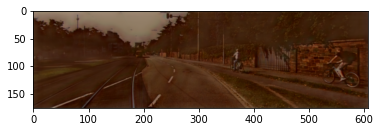

In [64]:
plt.imshow(np.transpose(img_out_y[0],[1,2,0]))

In [65]:
onnx-tf convert -t ffa.onnx -o tf_ffa.pb

SyntaxError: ignored

In [66]:
import onnx-tf

SyntaxError: ignored

In [67]:
it clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow

SyntaxError: ignored

In [ ]:
pip install onnx2keras

In [ ]:
pip install pytorch2keras

In [82]:
import onnx
from onnx2keras import onnx_to_keras

# Load ONNX model
onnx_model = onnx.load('ffa.onnx')

# Call the converter (input - is the main model input name, can be different for your model)
k_model = onnx_to_keras(onnx_model,["input"])

AttributeError: ignored

In [79]:
model = onnx.load('ffa.onnx')
output = model.graph.output

input_all = model.graph.input

In [ ]:
!git clone https://github.com/onnx/onnx-tensorflow.git


In [86]:
cd onnx-tensorflow/

/content/onnx-tensorflow


In [88]:
!onnx-tf convert -i /path/to/input.onnx -o /path/to/output

/bin/bash: onnx-tf: command not found


In [ ]:
!pip install onnx-tf

In [161]:
!onnx-tf convert -i ffa.onnx -o tf_ffa

2021-06-02 07:06:58,883 - onnx-tf - INFO - Start converting onnx pb to tf pb:
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
2021-06-02 07:07:35,656 - onnx-tf - INFO - Converting completes successfully.
INFO:onnx-tf:Converting completes successfully.


In [97]:
import tensorflow as tf

In [118]:
model=tf.saved_model.load('./tf_ffa/')

In [119]:
model.summary()

AttributeError: ignored

In [ ]:
img = Image.open("/content/drive/MyDrive/test_set/hazy/0_kitti_hazy.png")
img=np.asarray(img)
img=img[:176,:608,:]

In [ ]:
o=model(np.expand_dims(img,axis=0))

In [160]:
import onnx
from onnx_tf.backend import prepare
 
onnx_model = onnx.load("ffa.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph("tf_ffa/")

KeyboardInterrupt: ignored

In [104]:
img.shape

(176, 608, 3)

In [126]:
 model = onnx.load('ffa.onnx')
 tf_rep = prepare(model) 

Image 1:


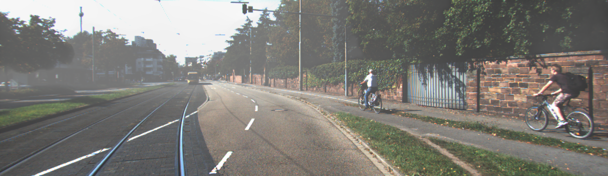

ValueError: ignored

In [159]:
 import numpy as np
 from IPython.display import display
 from PIL import Image
 print('Image 1:')
 img = Image.open('/content/drive/MyDrive/test_set/hazy/0_kitti_hazy.png').resize((608,176))

 display(img)
 img=np.asarray(img)
 img=np.reshape(img,(176,608,3))
 #a=np.random.randn(3,176,608)
 output = tf_rep.run(np.asarray(img, dtype=np.float32)[np.newaxis, :, :])

 #print('The digit is classified as ', np.argmax(output))
 #print('Image 2:')
 #img = Image.open('three.png').resize((28, 28)).convert('L')
 #display(img)
 #output = tf_rep.run(np.asarray(img, dtype=np.float32)[np.newaxis, np.newaxis, :, :])
 #print('The digit is classified as ', np.argmax(output)) 

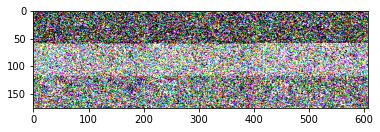

In [158]:
plt.imshow(output[0][0].reshape(176,608,3))

In [162]:
model = pytorch_to_keras(net,input_var,
[input_var.shape[-3:]],
change_ordering=True,
verbose=False,
name_policy="keep",
)


NameError: ignored